# Проанализируем данные популярного сервиса аренды самокатов GoFast.

Нам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируем данные и проверим некоторые гипотезы, которые могут помочь бизнесу вырасти.

# План действий
- загрузка данных;
- предобработка данных;
- исследовательский анализ данных;
- объединение данных;
- подсчет выручки;
- проверка гипотез;
- распределения.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statistics

from scipy import stats as st
from scipy.stats import binom, norm

from math import sqrt

#### Шаг 1. Загрузка данных

Загрузим информацию о пользователях, их поездках и подписках.

In [2]:
data_users = pd.read_csv('/datasets/users_go.csv')

Загрузим информацию о поездках пользователей.

In [3]:
data_rides = pd.read_csv('/datasets/rides_go.csv')

Загрузим информацию о типах подписок.

In [4]:
data_subscription = pd.read_csv('/datasets/subscriptions_go.csv')

Осмотрим данные датафреймов и изучим данные о них.

Рассмотрим датафрейм пользователей.

In [5]:
#pd.set_option('display.max_columns', None)
data_users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [6]:
print(f"Всего строк: {len(data_users)}")
print()
data_users.info()

Всего строк: 1565

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


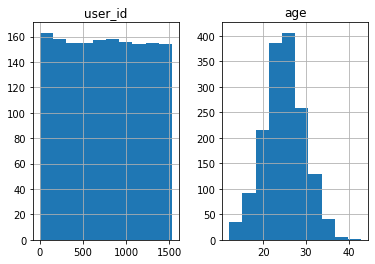

In [7]:
data_users.hist()
plt.show()

Вывод по таблице с пользователями:
- названия столбцов не требуют изменений;
- во всех столбцах отсутсвуют пропуски;
- неравномерность в столбце `user_id` может свидетельствовать и дубликатах.

Рассмотрим таблицу поездок.

In [8]:
data_rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [9]:
print(f"Всего строк: {len(data_rides)}")
print()
data_rides.info()

Всего строк: 18068

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


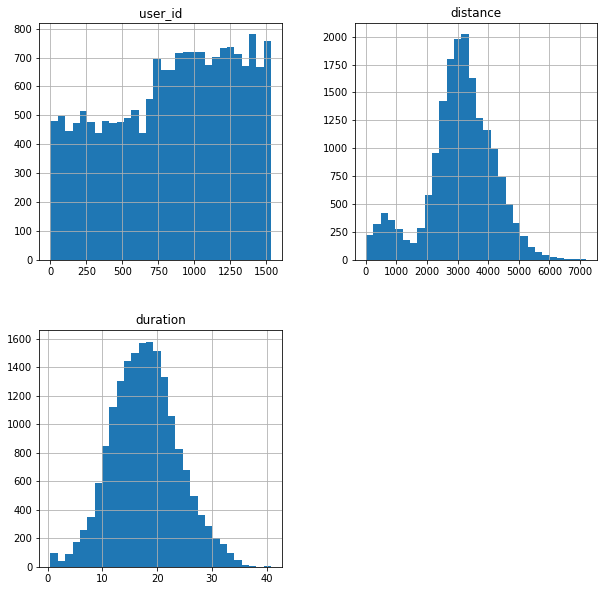

In [10]:
data_rides.hist(bins=30, figsize=(10,10))
plt.show()

Вывод по таблице поездок:
- названия столбцов не требуют изменений;
- во всех столбцах отсутсвуют пропуски;
- пользователи с id больше 700 чаще совершали повторные поездки;
- столбец `distance` имеет нормальное распределение и 2 явных пиковых значения. Возможные причины возникновения: 2 скоростных режима у самокатов;
- столбец `duration` имеет нормальное распределение без особо выбивающихся значений. Следует обратить внимание на значения близкие к нулю;
- столбец `date` необходимо привести к типу даты pandas.

Рассмотрим таблицу тарифов.

In [11]:
data_subscription

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Таблица является вспомогательной и не требует изменений.

#### Шаг 2. Предобработка данных

Приведем столбец `date` к типу даты pandas

In [12]:
data_rides['date'] = pd.to_datetime(
    data_rides['date'], format='%Y-%m-%d'
)

Создадим новый столбец с номером месяца на основе столбца `date`

In [13]:
data_rides['month_of_ride'] = data_rides['date'].dt.month

In [14]:
print(f"Дата первой поездки {min(data_rides['date'])}", f"Дата последней поездки {max(data_rides['date'])}", sep='\n')

Дата первой поездки 2021-01-01 00:00:00
Дата последней поездки 2021-12-30 00:00:00


Проверим наличие пропущенных значений и дубликатов в датафреймах. Обработаем их, если такие значения присутствуют.

Рассмотрим явные дубликаты.

In [15]:
print(f"Количество явных дубликатов датафрейма пользователей до обработки: \
{data_users.duplicated().sum()}")

data_users = data_users.drop_duplicates()

print(f"Количество явных дубликатов датафрейма пользователей после обработки: \
{data_users.duplicated().sum()}")

Количество явных дубликатов датафрейма пользователей до обработки: 31
Количество явных дубликатов датафрейма пользователей после обработки: 0


In [16]:
print(f"Количество явных дубликатов датафрейма поездок: {data_rides.duplicated().sum()}")

Количество явных дубликатов датафрейма поездок: 0


Рассмотрим неявные дубликаты

In [17]:
data_users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

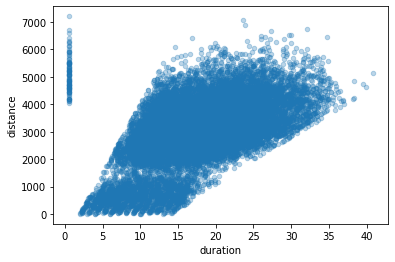

In [18]:
data_rides.plot.scatter(
    x='duration',
    y='distance',
    alpha=0.3,
)
plt.show()

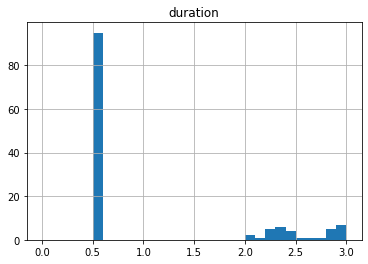

Медианное значение для выброса по времени = 0.5:     5113.176548536017
Медианное значение для отрезка времени (29; 31):     4032.3558527581467
Медианное значение для отрезка времени (34; 36):     4495.0158461350675
Медианное значение для отрезка времени (39; 41):     4845.801153185169


In [19]:
data_rides.hist('duration', bins=30, range=(0, 3))
plt.show()

print(f"Медианное значение для выброса по времени = 0.5: \
    {data_rides.loc[(data_rides['duration'] < 2), 'distance'].mean()}")
print(f"Медианное значение для отрезка времени (29; 31): \
    {data_rides.loc[(data_rides['duration'] > 29) & (data_rides['duration'] < 31), 'distance'].mean()}")
print(f"Медианное значение для отрезка времени (34; 36): \
    {data_rides.loc[(data_rides['duration'] > 34) & (data_rides['duration'] < 36), 'distance'].mean()}")
print(f"Медианное значение для отрезка времени (39; 41): \
    {data_rides.loc[(data_rides['duration'] > 39) & (data_rides['duration'] < 41), 'distance'].mean()}")


Наблюдаем выбросы столбца `duration` для значения 0.5. Гипотеза: время указано не в минутах, а в часах.

Медианное значение дистанции поездки при ~30 минутах отличается на 1000 метров, но данные несут необходимые финансовые данные и удалять их не рекомендуется. Заменим выбивающиеся значения в зависимости от дистанции, чтобы оказать меньше влияния на исходные данные.

*Преподаватель из каната проекта рекомендовал просто изучить данный вопрос (предложил гипотезу: "0.5 указано в часах") и предложить гипотезы, однако, я бы поступил следующим образом (код комментарием в ячейке ниже), либо удалил эти данные, поскольку их не значительное количество.*

In [20]:
data_rides.loc[(data_rides['duration'] == 0.5) & (data_rides['distance'] < 5000), 'duration'] = 30
data_rides.loc[(data_rides['duration'] == 0.5) & (data_rides['distance'] >= 5000) & (data_rides['distance'] < 6000), 'duration'] = 35
data_rides.loc[(data_rides['duration'] == 0.5) & (data_rides['distance'] >= 6000), 'duration'] = 40

In [21]:
# data_rides.plot.scatter(
#     x='duration',
#     y='distance',
#     alpha=0.1,
# )
# plt.show()

Итог:
- привели столбец `data_rides['date']` к нужному формату;
- данные предоставлены только за 2021 год;
- удалены дубликаты в датафрейме пользователей;
- устранены выбивающиеся значения столбца `data_rides['duration']`;
- проверены неявные дубликаты в столбце `data_users['city']`.

#### Шаг 3. Исследовательский анализ данных

Опишим и визуализируем общую информацию о пользователях и поездках:
##### Частота встречаемости городов

In [22]:
data_users.value_counts('city')

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
dtype: int64

Что удивительно, больше всего пользователей из небольшого города Пятигорск. А из Москвы пользователей на четверть меньше.

In [23]:
(data_users
 .pivot_table(index=['subscription_type', 'city'],
              values='user_id',
              aggfunc='count')
 .sort_values(by=['subscription_type', 'user_id'], ascending=False)
)

user_id
subscription_type city                   
ultra             Пятигорск            94
                  Екатеринбург         92
                  Омск                 91
                  Ростов-на-Дону       89
                  Сочи                 86
                  Москва               84
                  Тюмень               82
                  Краснодар            81
free              Пятигорск           125
                  Екатеринбург        112
                  Краснодар           112
                  Ростов-на-Дону      109
                  Сочи                103
                  Тюмень               98
                  Омск                 92
                  Москва               84

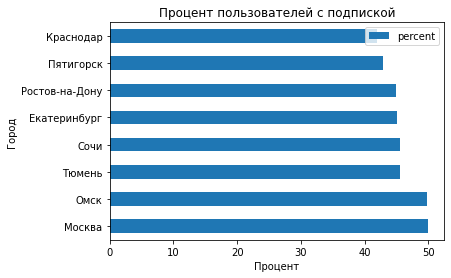

In [24]:
sub_percent = {'city':[], 'percent':[]}

for city in data_users['city'].unique():
    percent = (data_users.loc[(data_users['subscription_type'] == 'ultra') & (data_users['city'] == city), 'subscription_type'].count() / \
          data_users.loc[(data_users['city'] == city), 'subscription_type'].count()) * 100
    sub_percent['city'].append(city)
    sub_percent['percent'].append(percent)

(pd.DataFrame.from_dict(sub_percent)
 .sort_values(by='percent', ascending=False)
 .plot.barh(x='city', y='percent')
)

plt.title("Процент пользователей с подпиской")
plt.xlabel("Процент")
plt.ylabel("Город")
plt.show()

А вот тут уже интереснее, поскольку соотношение числа пользователей с подпиской и без явно лучше в Москве. 
##### Соотношение пользователей с подпиской и без подписки

In [25]:
len(data_users.loc[data_users['subscription_type'] == 'ultra']) / \
    len(data_users['subscription_type'])

0.4556714471968709

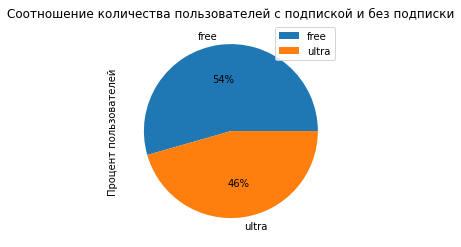

In [26]:
# (data_users
#  .pivot_table(index='subscription_type', values='user_id', aggfunc='count')
#  .plot.barh()
# )
# plt.title("Соотношение количества пользователей с подпиской и без подписки")
# plt.xlabel("Количество пользователей")
# plt.ylabel("Тип подписки")
# plt.show()

(data_users
 .pivot_table(index='subscription_type', values='user_id', aggfunc='count')
 .plot.pie(y='user_id', autopct='%1.0f%%')
)
plt.title("Соотношение количества пользователей с подпиской и без подписки")
plt.ylabel("Процент пользователей")
plt.show()

Почти половина всех пользователей (45.6%) купили подписку.

<!-- Разница в частоте покупки подписки почти 10% между Москвой и Краснодаром -->

##### Возраст пользователей

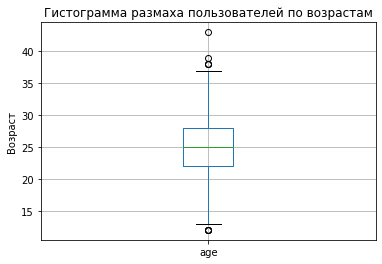

Список характерных значений для возрастов:
count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64


In [27]:
data_users.boxplot('age')
# data_users.hist('age', bins=32, range=(12, 43))
plt.title("Гистограмма размаха пользователей по возрастам")
plt.ylabel("Возраст")
plt.show()

print("Список характерных значений для возрастов:")
print(data_users['age'].describe())

Среднестатистическому пользователю от 22 до 28 лет. Однако, явно бросается в глаза отсутствие клиентов старше 43 лет, они не спешат пользоваться самокатами.

Диаграмма размаха выглядит, как по учебнику и имеет редкие выбивающиеся значения.

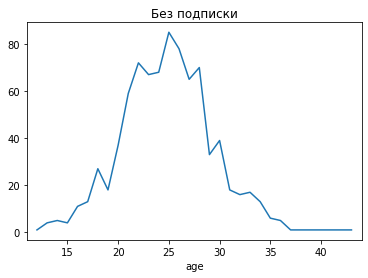

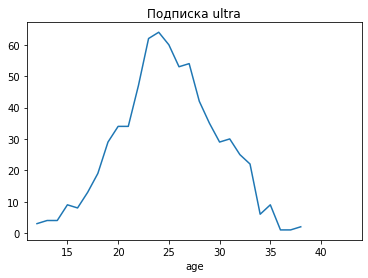

In [28]:
(data_users
 .query("subscription_type == 'free'")
 .pivot_table(index='age', aggfunc='count')
 ['user_id']
 .plot(title='Без подписки', xlim=(11, 44))
)
plt.show()

(data_users
 .query("subscription_type == 'ultra'")
 .pivot_table(index='age', aggfunc='count')
 ['user_id']
 .plot(title='Подписка ultra', xlim=(11, 44))
)
plt.show()

Заметно небольшое увеличение процента пользователей с подпиской в возрасте около 30 лет.

##### Расстояние, которое пользователь преодолел за одну поездку

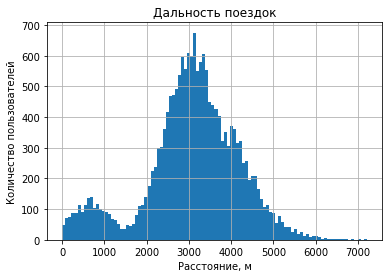

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

In [29]:
data_rides.hist('distance', bins=100)
plt.title("Дальность поездок")
plt.xlabel("Расстояние, м")
plt.ylabel("Количество пользователей")
plt.show()

data_rides['distance'].describe()

- имеются околонулевые значения. Гипотезы: сбои в фиксации пройденного расстояния, ограничения запаса батареи, ошибка порядка значения (например, значения внесены не в метрах, а в километрах);
- два явно выраженных пиковых значения. Как и было сказано, предполагаемся гипотеза: 2 режима скорости самоката (например: обычный и экономичный);
- обычное пройденное рассотяние составляет два-четрые киллометра.

##### Продолжительность поездок

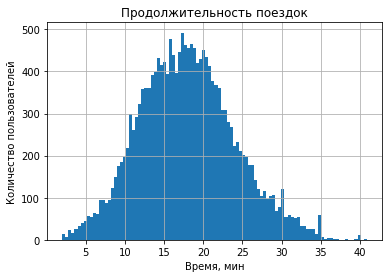

count    18068.000000
mean        17.976724
std          6.065844
min          2.035632
25%         13.697117
50%         17.750643
75%         21.824361
max         40.823963
Name: duration, dtype: float64

In [30]:
data_rides.hist('duration',bins=100)
plt.title("Продолжительность поездок")
plt.xlabel("Время, мин")
plt.ylabel("Количество пользователей")
plt.show()

data_rides['duration'].describe()

- распределение нормальное без выбивающихся значений;
- распределение симметричное, можно считать медиану (или моду) - мат. ожиданием.

#### Шаг 4. Объединение данных

##### Объединим данные о пользователях, поездках и подписках в один датафрейм.

In [31]:
data = data_users.merge(data_rides, on='user_id')

In [32]:
data = data.merge(data_subscription, on='subscription_type')

In [33]:
print(f'Строк до объединения: {len(data_rides)}')
print(f'Строк после объединения: {len(data)}')

Строк до объединения: 18068
Строк после объединения: 18068


##### Создадим ещё два датафрейма из датафрейма, созданного на этапе 4.1:
- c данными о пользователях без подписки;
- с данными о пользователях с подпиской.

In [34]:
data_free = data.query('subscription_type == "free"')

In [35]:
data_ultra = data.query('subscription_type == "ultra"')

##### Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

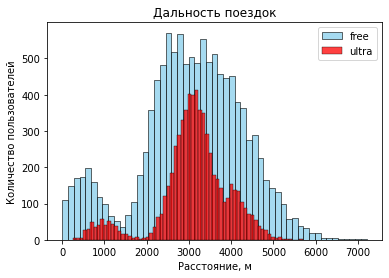

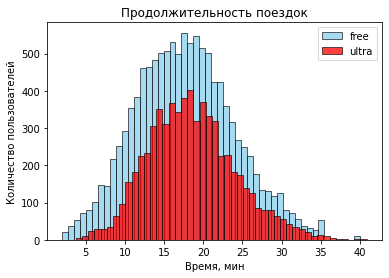

In [36]:
# sns.set(rc={'figure.figsize':(15, 5)}) # Зададим размер графиков

sns.histplot(data=data_free, x="distance", color="skyblue", label="free")
sns.histplot(data=data_ultra, x="distance", color="red", label="ultra")
plt.legend() 
plt.title("Дальность поездок")
plt.xlabel("Расстояние, м")
plt.ylabel("Количество пользователей")
plt.show()

sns.histplot(data=data_free, x="duration", color="skyblue", label="free")
sns.histplot(data=data_ultra, x="duration", color="red", label="ultra")
plt.legend() 
plt.title("Продолжительность поездок")
plt.xlabel("Время, мин")
plt.ylabel("Количество пользователей")
plt.show()

Особых примечаний нет, данные пропорциональны равномерно.
- при бесплатных поездках, гораздо сильнее выбивается первое пиковое значение дистанции. Гипотезы: разовые пользователи;
- у пользователей с подпиской появилось третье пиковое значение ~4000 метров. Гипотезы: типизация поездок у  людей с подпиской.

*Пользуюсь seaborn впервые(знал минимум о нём), поэтому раньше в проекте не использовал :`)  Использовал, чтобы было одновременно 2 графика и при этом была подписана категория на графике. Позже вспомнил про агрумент ax*

#### Шаг 5. Подсчёт выручки

##### 
Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4. Найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [37]:
# округлим значения времени
data['duration'] = np.ceil(data['duration']) 

In [38]:
data_by_month = (data
 .pivot_table(index=['user_id', 'subscription_type', 'month_of_ride'],
              values=['distance', 'duration', 'minute_price', 'start_ride_price', 'subscription_fee'],
              aggfunc={'user_id': 'count',
                       'minute_price':'median', 'start_ride_price':'median', 'subscription_fee':'median',
                       'distance':'sum', 'duration':'sum'})
)
data_by_month = data_by_month.rename(columns={'user_id':'rides_counter'})
data_by_month.head(10)

distance  duration  minute_price  \
user_id subscription_type month_of_ride                                         
1       ultra             1               7027.511294      42.0             6   
                          4                754.159807       7.0             6   
                          8               6723.470560      46.0             6   
                          10              5809.911100      32.0             6   
                          11              7003.499363      56.0             6   
                          12              6751.629942      28.0             6   
2       ultra             3              10187.723006      63.0             6   
                          4               6164.381824      40.0             6   
                          6               3255.338202      14.0             6   
                          7               6780.722964      48.0             6   

                                         start_ride_price  subscription_fee  \
user_id subscription_type month_of_ride                                       
1       ultra             1                             0               199   
                          4                             0               199   
                          8                             0               199   
                          10                            0               199   
                          11                            0               199   
                          12                            0               199   
2       ultra             3                             0               199   
                          4                             0               199   
                          6                             0               199   
                          7                             0               199   

                                         rides_counter  
user_id subscription_type month_of_ride                 
1       ultra             1                          2  
                          4                          1  
                          8                          2  
                          10                         2  
                          11                         3  
                          12                         2  
2       ultra             3                          3  
                          4                          2  
                          6                          1  
                          7                          2

##### 
В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обратимся к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округлим до следующего целого числа.

In [39]:
# функция возвращающая сумму выручки за месяц у пользователся
def revenue(row):
    rides_counter = row['rides_counter']
    start_ride_price = row['start_ride_price']
    duration = row['duration']
    minute_price = row['minute_price']
    subscription_fee = row['subscription_fee']
    
    revenue = (rides_counter * start_ride_price) + (duration * minute_price) + subscription_fee # сумма старта + сумма поездки + сумма подписки

    return revenue

# создадим столбец с помесячной выручкой
data_by_month['revenue'] = data_by_month.apply(revenue, axis=1)

In [40]:
data_by_month.head()

distance  duration  minute_price  \
user_id subscription_type month_of_ride                                        
1       ultra             1              7027.511294      42.0             6   
                          4               754.159807       7.0             6   
                          8              6723.470560      46.0             6   
                          10             5809.911100      32.0             6   
                          11             7003.499363      56.0             6   

                                         start_ride_price  subscription_fee  \
user_id subscription_type month_of_ride                                       
1       ultra             1                             0               199   
                          4                             0               199   
                          8                             0               199   
                          10                            0               199   
                          11                            0               199   

                                         rides_counter  revenue  
user_id subscription_type month_of_ride                          
1       ultra             1                          2    451.0  
                          4                          1    241.0  
                          8                          2    475.0  
                          10                         2    391.0  
                          11                         3    535.0

#### Шаг 6. Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.

##### Гипотеза 1
Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверим гипотезу. Используем исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Как было видно на графиках ранее, значения имеют нормально распределение.
- нулевая гипотеза - пользователи с подпиской тратят столько же времени на поездки
- альтернативная гипотеза - пользователи с подпиской тратят больше же времени на поездки

In [41]:
alpha = 0.05 # уровень статистической значимости

results = st.ttest_ind(data_ultra['duration'], data_free['duration'], alternative='greater', equal_var=False)
# False, т.к. размеры выборок отличаются в 2 раза
print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 1.1594843183369864e-22
Отвергаем нулевую гипотезу


In [42]:
print("Список характерных значений времени пользователей с подпиской:")
data_ultra['duration'].describe()

Список характерных значений времени пользователей с подпиской:


count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

In [43]:
print("Список характерных значений времени пользователей без подписки:")
data_free['duration'].describe()

Список характерных значений времени пользователей без подписки:


count    11568.000000
mean        17.659106
std          6.304446
min          2.035632
25%         13.127082
50%         17.446822
75%         21.779484
max         40.000000
Name: duration, dtype: float64

Метод describe подтверждает, что выдвинутую нулевую гипотезу следует отвергнуть. По списку характерный значений видно, что имеет место альтернативная гипотеза о том, что пользователи с подпиской тратят больше времени на поездки.

Стоит заметить, что разница не столь велика.

##### Гипотеза 2
Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката.
Проверим, можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
Проверим гипотезу и сделайте выводы.

- нулевая гипотеза - расстояние, которое проезжают пользователи с подпиской за одну поездку составляет 3130 метров.
- альтернативная гипотеза - расстояние, которое проезжают пользователи с подпиской за одну поездку более 3130 метров.

In [44]:
optimal_value = 3130 # желаемый предел расстояния
alpha = 0.05 # уровень статистической значимости

results = st.ttest_1samp(
    data_ultra['distance'], 
    optimal_value,
    alternative = 'greater'
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')


p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


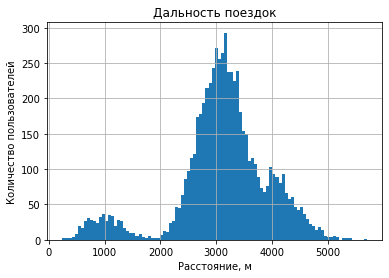

Список характерных значений пройденного расстояния с подпиской:


count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

In [45]:
data_ultra['distance'].hist(bins=100)
plt.title("Дальность поездок")
plt.xlabel("Расстояние, м")
plt.ylabel("Количество пользователей")
plt.show()

print("Список характерных значений пройденного расстояния с подпиской:")
data_ultra['distance'].describe()

Выдвинутая гипотеза о близости значений к 3130 метрам усиливается гистограммой и общей информацией о столбце.

Можно сказать, что расстояние, которое проезжает часть пользователей с подпиской за одну поездку, не превышает 3130 метров.

Однако, довольно много пользователей проезжает и большее расстояние.

##### Гипотеза 3
Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

- нулевая гипотеза - помесячная выручка от пользователей с подпиской `равна` выручке пользователей без подписки;
- альтернативная гипотеза - помесячная выручка от пользователей с подпиской `больше` выручкы пользователей без подписки.

In [46]:
data_by_month.query("subscription_type == 'free'")

distance  duration  minute_price  \
user_id subscription_type month_of_ride                                         
700     free              1               2515.690719      15.0             8   
                          2              13446.659764      89.0             8   
                          3               3798.334905      19.0             8   
                          4               2984.551206      16.0             8   
                          6               5927.650988      29.0             8   
...                                               ...       ...           ...   
1534    free              6               3409.468534      26.0             8   
                          8               7622.453034      48.0             8   
                          9               4928.173852      23.0             8   
                          11             13350.015305      78.0             8   
                          12              2371.711192      16.0             8   

                                         start_ride_price  subscription_fee  \
user_id subscription_type month_of_ride                                       
700     free              1                            50                 0   
                          2                            50                 0   
                          3                            50                 0   
                          4                            50                 0   
                          6                            50                 0   
...                                                   ...               ...   
1534    free              6                            50                 0   
                          8                            50                 0   
                          9                            50                 0   
                          11                           50                 0   
                          12                           50                 0   

                                         rides_counter  revenue  
user_id subscription_type month_of_ride                          
700     free              1                          1    170.0  
                          2                          5    962.0  
                          3                          1    202.0  
                          4                          1    178.0  
                          6                          2    332.0  
...                                                ...      ...  
1534    free              6                          2    308.0  
                          8                          2    484.0  
                          9                          1    234.0  
                          11                         4    824.0  
                          12                         1    178.0  

[6798 rows x 7 columns]

In [47]:
data1 = data_by_month.query("subscription_type == 'ultra'") # пользователи с подпиской
data2 = data_by_month.query("subscription_type == 'free'") # пользователи без подписки

alpha = 0.05 # уровень статистической значимости

results = st.ttest_ind(data1['revenue'], data2['revenue'], alternative='greater', equal_var=False)
# False, т.к. размеры выборок отличаются в 2 раза
print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 7.108915382913362e-32
Отвергаем нулевую гипотезу


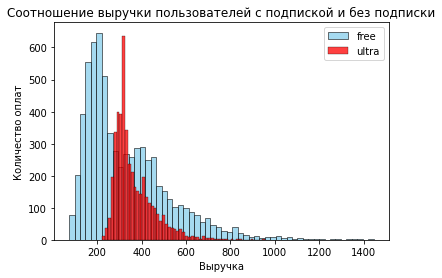

In [48]:
sns.histplot(data=data2, x="revenue", color="skyblue", label="free")
sns.histplot(data=data1, x="revenue", color="red", label="ultra")
plt.legend() 
plt.title("Соотношение выручки пользователей с подпиской и без подписки")
plt.xlabel("Выручка")
plt.ylabel("Количество оплат")
plt.show()


Выдвинутая гипотеза о том, что выручка равна отвергается явно. Графики усиливают гипотезу, что "выгоднее" пользователи с подпиской. Средняя выручка за месяц за пользователей с подпиской выше.

##### Вопрос
Представим такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

scipy.stats.ttest_rel(before, after)

В данному случае необходимо проверить гипотезу о равенстве средних двух генеральных совокупностей для зависимых (парных) выборок.

#### Шаг 7. Распределения

##### Распределение 1

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соотвествующий платёж. 

Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %.

Подберем параметры распределения, описывающего эту ситуацию, построим график распределения и сформулируйте ответ на вопрос о количестве промокодов.

In [49]:
n = 1170 # количество попыток
p = 0.1 # вероятность успеха

distr = []

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)

/opt/conda/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


Вероятности биномиального распределения:


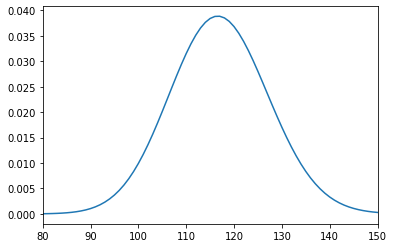

In [50]:
print('Вероятности биномиального распределения:')
distr = pd.Series(distr)
distr.plot(xlim=(80,150))
plt.show()

In [51]:
# математическое ожидание биномиального распределения
mu = n * p
# стандартное отклонение биномиального распределения
sigma = sqrt(n * p * (1 - p))
# задаём нормальное распределение с математическим ожиданием 1000 
# и стандартным отклонением 100
distr_norm = st.norm(mu, sigma) 

# значение, для которого хотим найти вероятность
x = 100

# считаем вероятность получить значение, равное x или меньше 
result = distr_norm.cdf(x)
print('Вероятность не выполнить план =', result*100)

Вероятность не выполнить план = 4.879359652776027


Чтобы вероятность не выполнить план (100 подписок) была примерно 5 %, необходимо раздать около 1170 промокодов.

##### Распределение 2

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

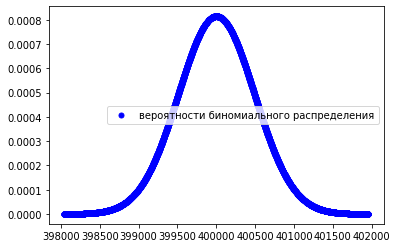

Условие аппроксимации не выполняется


In [52]:
# зададим функцию, которая выдаёт <num> чисел,
# равномерно распределённых от <start> до <stop>
# (понадобится для визуализации нормального распределения)
def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result
 
# задаём параметры биномиального распределения
n_2 = 1000000
p_2 = 0.4

# границы промежутка, в котором будем строить аппроксимацию
left = int(n_2 * p_2 - 4 * sqrt(n_2 * p_2 * (1 - p_2)))
right = int(n_2 * p_2 + 4 * sqrt(n_2 * p_2 * (1 - p_2)))
 
# зададим набор значений биномиальной величины на выбранном промежутке:
# все неотрицательные целые числа от left до right
x = list(range(max(0, left), right))
# рисуем график биномиального распределения
ax = plt.subplot()
# используем синие о-образные маркеры и размер маркера 5
ax.plot(x, binom.pmf(x, n_2, p_2), 'bo', ms=5,
        label='вероятности биномиального распределения')

# мат.ожидание и дисперсия биномиального распределения
mu_2 = n_2 * p_2
sigma_2 = sqrt(n_2 * p_2 * (1 - p_2))
 
# # рисуем график нормального распределения:
# # получим список из 100 чисел от left до right
# x = linspace(left, right, 100)
# # используем красную линию ширины 3 и прозрачности 0.3
# ax.plot(x, norm.pdf(x, mu_2, sigma_2), 'r-', lw=3, alpha=0.3, label='плотность вероятности нормального распределения')

# настраиваем оптимальное расположение легенды и выводим график
ax.legend(loc='best')
plt.show()



# выводим, выполняется ли наше условие аппроксимации:
# лежит ли mu ± 3 sigma в промежутке от 0 до n:
if (mu_2 - (3 * sigma_2) >= 0) and ((mu_2 + (3 * sigma_2) <= n)):
    print('Условие аппроксимации выполняется')
else:
    print('Условие аппроксимации не выполняется')


In [53]:
distr_norm_2 = st.norm(mu_2, sigma_2) 

# значение, для которого хотим найти вероятность
x_2 = 399500

# считаем вероятность получить значение, равное x или меньше 
result_2 = distr_norm_2.cdf(x_2)
print('Вероятность, что уведомления откроют не более 399.5 тыс. пользователей =', result_2*100)

Вероятность, что уведомления откроют не более 399.5 тыс. пользователей = 15.371708296369768


# Итоговый вывод

1 Предобработка данных.
- устранены явные дубликаты;
- проверено наличие неявных дубликатов;
- устанены основные выбивающиеся значения;
- проверены пустные значения.

2 исследовательский анализ данных.
- самым популярным городом среди пользователей является Пятигорск;
- подписку купили 45,6 % пользователей;
- средний возраст пользователся от 22 до 28 лет. Самому возрастному пользователю 43 года;
- в среднем пользователи проезжают от 2000 до 4000 метров;
- средняя продолжительность по времени от 13 до 30 минут.

3 Объединение данных
- проведено объединение данных о пользователях и подписках в один датафрейм;
- визуализирована информация о расстоянии и времени поездок для пользователей без подписки и с подпиской.

4 Подсчет выручки
- создадин датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными;
- найдено суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц;
- добавлена информация с помесячной выручкой каждого клиента.

5 Проверка гипотез
- не опровергнута гипотеза о том, что пользователи с подпиской тратят времени на поездки. Статистические данные усиливают данную гипотезу;
- нельзя сказать, что пользователи проезжают менее 3130 метров за поездку. Данное значения является близким к серднему;
- не опровергнута гипотеза о том, что пользователи с подпиской приносят больше выручки в месяц, чем пользователи без подписки. Представленные графики усиливают данную гипотезу.

6 Распределения
- чтобы вероятность не выполнить план (100 подписок после раздачи промокодов) была примерно 5 %, необходимо раздать около 1170 промокодов.
- если разослать 1 млн. уведомлений, то вероятность, что уведомления откроют не более 399.5 тыс. пользователей ~= 15.37 %